# Use case: O2C - Delivery Delay Prediction
For this example, we are going to look at delivery delay prediction. We are going to build a **binary** classification model with the two possible classes 1 (delayed) and 0 (not delayed).

**To get your own copy of this notebook run:**

In [1]:
from celonis_ml.templates import notebooks

Ignoring 02_delivery_delay_prediction.ipynb because file already exists.


### 1. Import the required packages

In [ ]:
from pathlib import Path

import joblib
import pandas as pd

from pycelonis import get_celonis
from celonis_ml.templates.demos import install_app, o2c_ddp_demo
from celonis_ml.data_preprocessing import FeatureRecommender
from celonis_ml.data_preprocessing.data_utils import push_table
from celonis_ml.helpers import plot_auc_for_result, set_log_level
from celonis_ml.trainers import TimeTranchesTrainer, CelonisMLTrainer

%matplotlib inline

### 2. Install or find the O2C Delivery Delay Prediction app in your team
This will install or find an analysis and optionally upload a demo data-model in your IBC team.<br>
If you have a workspace which uses **standard SAP Order to Cash** datamodel, enter in the cell bellow the name of a workspace to put the demo analysis there. This way you don't have to push our demo data, and the process will be faster.<br> If you don't have the required data, leave the cell as it is.

#### If `taget_workspace` and `target_analysis` both can't be found, a data pool, data model, workspace and analysis with demo data will be installed

In [3]:
celonis = get_celonis()

2021-02-18 18:33:07 - pycelonis: Login successful! The Application Key currently has access to 488 Analyses and to 165 Data Pools.


In [4]:
# Select a workspace you want to connect to. An analysis will be created in the workspace.
target_workspace = "02_SAP ECC Order to Cash"
workspace = celonis.workspaces.find(target_workspace)

In [5]:
analysis_name = "O2C - Delivery Delay Prediction"

In [6]:
analysis = workspace.analyses.find(analysis_name, False)
if not analysis:
    analysis = install_app(demo=o2c_ddp_demo,
                           celonis=celonis,
                           target_workspace=workspace,
                           analysis_name=analysis_name)
analysis.web_link

## Now, go to the analysis and start with the step "Delivery Delay Prediction 1/5"

## ML-WORKBENCH 1/2 - Feature recommendation

### 1. Set up the initial variables
Enter the shared selection URL here

In [7]:
shared_selection_url = """
my_feature_recommendation_url
"""

In [8]:
data_dir = Path("ddp_data444")

### 2. Run Feature Recommendation

In [ ]:
# Estimated duration: 12 minutes
fr = FeatureRecommender(analysis, tables_to_include=["VBAP"], shared_selection_url=shared_selection_url)
recommendations = fr.run(push=False)

In [ ]:
recommendations.head()

In [ ]:
# Estimated duration: 2 minutes
analysis.datamodel.push_table(
    recommendations, "Py_DDP_Feature_recommendation", if_exists="replace", reload_datamodel=True, wait_for_finish=True
)

## Now go to the analysis and continue with step "Feature Recommendation 4/5"

## ML-WORKBENCH 2/2 - Model training and prediction
Enter you new selection url below:

In [8]:
shared_selection_url = """
my_model_training_url
"""

### 1. Initialize a trainer

The MLSuite supports three different algorithms for building a binary classification model: `'lgbm_classifier'`, `'rf_classifier'` and `'lr_classifier'`. <br>
We recommend people that are new to machine learning to stick with the default option of this notebook. ML wizards can play around with the other options and see which one gives better results.

In [11]:
model_name = "lgbm_classifier"

In [12]:
trainer = CelonisMLTrainer(cel_analysis=analysis, data_dir=data_dir, shared_selection_url=shared_selection_url)

### 2. Train it and push results
After initializing the trainer, we now need to feed it with data and train it. You can specify the hyper-parameter settings of the model with the `params` attribute. Novices are again recommended to stick to the default settings. If you already have some experience with machine learning, you can check the documentation and tune the hyperparameters.

Docs for lgbm_classifier: https://lightgbm.readthedocs.io/en/latest/Parameters.html <br>
Docs for rf_classifier: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html <br>
Docs for lr_classifier: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [ ]:
# Estimated duration: 3 minutes
params = {"num_leaves": 32, "max_depth": 16, "learning_rate": 0.1, "num_iterations": 20}
train_results, test_performance, feature_importance = trainer.train(
    model_name=model_name, params=params, sample=True, sample_size=10000
)

In [ ]:
# Estimated duration: 3 minutes
push_table(analysis.datamodel, train_results, "Py_DDP_Evaluation_results", if_exists="replace")
push_table(analysis.datamodel, test_performance, "Py_DDP_Test_performance", add_table_links=False, if_exists="replace")
push_table(
    analysis.datamodel,
    feature_importance,
    "Py_DDP_Feature_importance",
    add_table_links=False,
    if_exists="replace",
    reload_datamodel=True,
)

### 3. Analyze test performance
The model has only learned from closed cases, because those are the cases for which we already know if the delivery was late or not. This also means, that we can now analyze how the model performs on these closed cases. For each case, `y_pred` contains the predicted label and `y_true` the true label. We provide a nice sheet in the analysis, where you can examine these results closely.

In [12]:
train_results.head()

,_CASE_KEY,usage,y_true,y_pred,model_name
0,2531,train,0,0.009471,lgbm_classifier
1,2000,train,0,0.031801,lgbm_classifier
2,7156,train,0,0.020041,lgbm_classifier
3,3516,train,0,0.023056,lgbm_classifier
4,6702,train,0,0.016136,lgbm_classifier


## Now, go to the analysis and check out the "Technical Performance Overview"

#### 3.a. Bonus tip!

As an example of other interesting things you can do in the ML Workbench (just like with any Jupyter Notebook environment), we show the following plots. Our algorithm stores the training dataset as a pandas DataFrame, which means you can also experiment with any other post-training analysis or visualization techniques that you are familiar with.

The AUC curve is a commonly used way to assess the quality of classification models. To put it simply, the more the orange line reaches the upper left, the better the model is. If the orange line coincides with the blue line, this is a bad sign: It means that the model is performing just as well as random predictions would.

ROC Score: 0.741


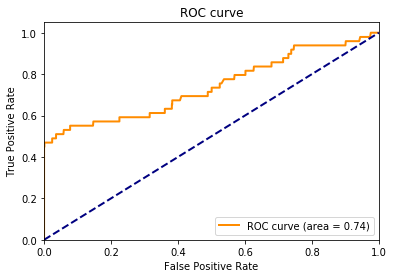

In [13]:
%matplotlib inline
plot_auc_for_result(train_results[train_results.usage == "test"])

### 4. Predict for open cases
If you have built your model and are happy with its performance on closed cases, it is time to start predicting on time delivery for open cases!

In [14]:
# Estimated duration: 1.5 minutes
predictions = trainer.predict(model_name=model_name)

2021-02-18 18:34:00 - celonis_ml.data_preprocessing.data_gathering: Connected to Datamodel: GOOD_DATA O2C datamodel - Working and Analysis: O2C - Delivery Delay Prediction
2021-02-18 18:34:08 - celonis_ml.data_preprocessing.data_gathering: Checking fingerprint... developmentNoneddp_data444predictiongeneric_dataloader
2021-02-18 18:34:08 - celonis_ml.data_preprocessing.data_gathering: Fingerprint found
2021-02-18 18:34:08 - celonis_ml.trainers.trainers: Start predicting...
2021-02-18 18:34:10 - celonis_ml.data_preprocessing.data_gathering: Obtaining data for prediction with cases table of shape: (40, 461)
2021-02-18 18:34:19 - celonis_ml.data_preprocessing.data_gathering: Final dataset for prediction has shape: (40, 480)
2021-02-18 18:34:20 - celonis_ml.trainers.trainers: Prediction results header:
               _CASE_KEY    y_pred       model_name
0  800:530010:0000910232  0.020852  lgbm_classifier
1  800:240010:0000427209  0.020852  lgbm_classifier
2  800:160010:0000276682  0.020100 

You can then look at your predictions...

In [15]:
predictions.head()

,_CASE_KEY,y_pred,model_name
0,800:530010:0000910232,0.020852,lgbm_classifier
1,800:240010:0000427209,0.020852,lgbm_classifier
2,800:160010:0000276682,0.020100,lgbm_classifier
3,800:140040:0000245149,0.017808,lgbm_classifier
4,800:270040:0000467397,0.020852,lgbm_classifier


...and also save them if you want:

In [21]:
dump_data_file(Path(data_dir / "pred_overall.parquet"), predictions)

### 5. Push prediction results back to Celonis
As a last step, you can push your results back into Celonis. The cell below will finish running once the data has been pushed to Celonis and the data model has been reloaded. This function will also verify the primary key of the case table and add the corresponding foreign key connections for you to be able to use it immediatly in your analysis.

In [ ]:
# Estimated duration: 2 minutes
push_table(analysis.datamodel, predictions, "Py_DDP_Predictions", if_exists="replace", reload_datamodel=True)

## Now go to the anlaysis and check the results in "Predictions"